# Example: Compute the Profit and Breakeven Points for Composite Option Contracts at Expiration

## Background
Call and put contracts can be combined to develop composite contract structures with interesting payoff diagrams. Let's limit our focus to contracts that have the same underlying asset and the same expiration date. A composite option contract be composed of $d$ legs (individual contracts) in the contract set $\mathcal{C}$ where each leg $i\in\mathcal{C}$ is written with respect to the same underlying stock `XYZ` and has the same expiration date. Then, the overall payoff of the composite contract $\hat{V}(S(T),K_{1},\dots,K_{d})$ is given by:


$$\hat{V}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}V_{i}(S(T),K_{i})$$


where $K_{i}$ denotes the strike price of contract $i\in\mathcal{C}$. The overall profit of the composite contract $\hat{P}$ is given by:


$$\hat{P}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}P_{i}(S(T),K_{i})$$


where $\theta_{i}$ denotes the direction of contract $i$: if contract $i$ is short (sold), then $\theta_{i}=-1$, otherwise $\theta_{i}=1$, $n_{i}$ denotes the copy number of contract $i$, ${V}_{i}(S(T),K_{i})$ denotes the payoff of contract $i$, and $P_{i}(S(T),K_{i})$ denotes the profit of contract $i$. Finally, the profit for contract of type $\star$ is given by:

$$P_{\star}(K,S(T)) = {V}_{\star}(K,S(T)) -  \mathcal{P}_{\star}(K,S(0))$$

where $\mathcal{P}_{\star}(K,S(0))$ denotes the premium of contract $\star$, and ${V}_{\star}(K,S(T))$ denotes the payoff of contract $\star$ at expiration.

## Learning Objectives
For this example, we will compute the profit diagrams at expiration for some common composite contracts. We downloaded the options chain (premium value versus as a function of strike price) for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) from [barchart.com](https://www.barchart.com). Currently, the share price of `AMD` is `S(0) = 117.50 USD/share`, and the average implied volatility for `AMD` options with `DTE = 31 days` is `IV = 51.75%`.

* __Objective 1__:  Examine vertical spreads, which are defined risk trades that make bullish or bearish directional assumptions and can be opened for a credit or debit.
* __Objective 2__: Explore long and short straddles, which are neutral trades that profit from share price movement in either direction.
* __Objective 3__: Analyze long and short strangles, which are another type of neutral trade that benefits from share price movement in any direction or no price movement at all.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages

The `Include.jl` file loads several packages that we use'll for our exercises:

* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality.

### Types

`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the excercises.

#### Contract models
The `MyEuropeanPutContractModel` and `MyEuropeanCallContractModel` types encode information about European `put` and `call` contracts:
* The field `K::Float64` is the strike price of the `put` (or `call`) contract
* The field `sense::Int64` encodes if the contract was sold (`sense = -1` short) or purcahsed (`sense = 1` long). 
* The `DTE::Float64` field encodes the number of days to expiration (DTE) of the contract
* The `IV::Float64` field encodes the implied volatility, i.e., the share price volatility of the underlying asset for this `put` or `call` contract
* The `premium::Union{Nothing, Float64}` field is the cost of the contract (what we'll be calculating in this example)
* The `ticker::Union{Nothing,String}` field encodes the symbol for a `put` or `call` contract, see [How to Read a Stock Options Ticker](https://polygon.io/blog/how-to-read-a-stock-options-ticker/).

The `MyAmericanPutContractModel` and `MyAmericanCallContractModel` types encode information about American `put` and `call` contracts:
* The field `K::Float64` is the strike price of the `put` (or `call`) contract
* The field `sense::Int64` encodes if the contract was sold (`sense = -1` short) or purcahsed (`sense = 1` long). 
* The `DTE::Float64` field encodes the number of days to expiration (DTE) of the contract
* The `IV::Float64` field encodes the implied volatility, i.e., the share price volatility of the underlying asset for this `put` or `call` contract
* The `premium::Union{Nothing, Float64}` field is the cost of the contract (what we'll be calculating in this example)
* The `ticker::Union{Nothing,String}` field encodes the symbol for a `put` or `call` contract, see [How to Read a Stock Options Ticker](https://polygon.io/blog/how-to-read-a-stock-options-ticker/).

### Functions

`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

#### Contracts
`build(model::Type{MyEuropeanPutContractModel}, data::NamedTuple) -> MyEuropeanPutContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyEuropeanPutContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyEuropeanCallContractModel}, data::NamedTuple) -> MyEuropeanCallContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyEuropeanCallContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyAmericanPutContractModel}, data::NamedTuple) -> MyEuropeanPutContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyAmericanPutContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyAmericanCallContractModel}, data::NamedTuple) -> MyEuropeanCallContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyAmericanCallContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

#### Payoff and Proft

`payoff(contracts::Array{T,1}, S::Array{Float64,1}) -> Array{Float64,2} where T <: AbstractContractModel`. The `payoff(...)` function
takes an array of contract models and an array of share prices at expiration and returns an array of payoff values for each contract where each row holds the payoff value for a particular future share price at expiration, and each column holds the payoff value for the contracts, where the columns are in the same order as the `contracts` array.

`profit(contracts::Array{T,1}, S::Array{Float64,1}) -> Array{Float64,2} where T <: AbstractContractModel`. The `profit(...)` function takes an array of contract models and an array of share prices at expiration and returns an array of profit values for each contract.  Each row of the array holds the payoff value for a particular future share price at expiration, while each column holds the profit value for a contract (in the same order as the `contracts` array).

In [1]:
include("Include.jl");

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


## Prerequisite: Load options chain dataset
To start, load the options data using using the `loadoptionsdata(...)` function and store the data in the `options_dataset` variable:

In [2]:
options_dataset = loadoptionsdata()

Row,Strike,Bid,Midpoint,Ask,Last,AVGIV,IV,Type
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,String7
1,35,82.45,83.03,83.6,79.5,0.5175,2.3033,Call
2,40,77.5,77.95,78.4,48.5,0.5175,1.8801,Call
3,45,72.85,73.15,73.45,69.9,0.5175,1.2223,Call
4,50,67.85,68.13,68.4,71.0,0.5175,1.4811,Call
5,55,62.85,63.18,63.5,61.08,0.5175,0.8203,Call
6,60,57.9,58.18,58.45,57.1,0.5175,1.1983,Call
7,65,52.95,53.25,53.55,52.66,0.5175,0.8171,Call
8,70,47.9,48.25,48.6,46.79,0.5175,0.6489,Call
9,75,43.05,43.33,43.6,43.01,0.5175,0.6885,Call


## Objective 1: Profit and loss diagrams for Vertical Spreads
[Vertical spreads](https://www.fidelity.com/bin-public/060_www_fidelity_com/documents/learning-center/Deck_Vertical-spreads.pdf), a defined risk directional strategy, involve buying and selling the same type of option with different strike prices and the same expiration date. This creates two legs, a long leg (the option purchased by the investor) and a short leg (the option sold by the investor).  The investor can use the strategy to take a position on whether the share price of the underlying stock, such as `XYZ`, will increase or decrease. 

### Bullish put credit spread
A put vertical spread is constructed by combining $2~\times$ `put` contracts, a short `put` contract generates income while the `long` put contract controls downside risk.  Let contract $j$ have a strike price of $K_{j}$ and premium $\mathcal{P}_{j}$. The share price at expiration is given by $S$. Finally, let contract 1 be the short leg $\theta_{1} = -1$ and contract 2 be the long leg $\theta_{2} = 1$. Then, the profit for a single `put` vertical spread at expiration is given by:

$$\hat{P} = -P_{1}+P_{2}$$

which, after substitution of the profit functions for a put contract, gives:

$$
\hat{P} = \left(K_{2} - S\right)^{+} - \left(K_{1} - S\right)^{+} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$$

where $V_{p} = (K-S)^{+}=\max(K-S,0)$ is the payoff function for a `put` contract. The first term is the net payout of the two legs of the spread, while the second term is the net cost of the two contracts. The maximum possible profit, loss, and breakeven conditions are given by:

* The maximum possible profit of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S\geq{K_{1}}$.
* The maximum possible loss of $K_{2} - K_{1} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S\leq{K_{2}}$.
* The vertical put spread will breakeven when $S =  K_{1}+\left(\mathcal{P}_{2} - \mathcal{P}_{1}\right)$.

Let's build a bullish put credit spread for `AMD` whose current share price is `S(0) = 117.50 USD/share`. This trade structure is constructed by selling (short) a `put` with strike $K_{1}$ and buying (long) a `put` with strike $K_{2}$, where $K_{1}<S(0)<K_{2}$. 

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = 130 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `long put` leg is given by $K_{2}$ = 110 USD/share with `DTE = 31 days`

### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

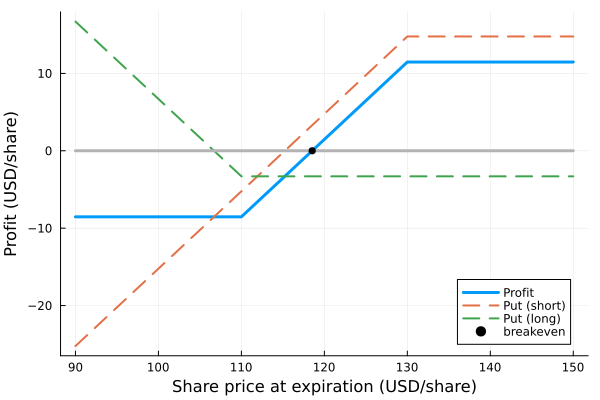

In [3]:
let

    K₁ = 130.0
    K₂ = 110.0
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Put"), options_dataset)[1,:Midpoint];
    
    
    put_contract_model_short = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = -1, copy = 1
    ));

    put_contract_model_long = build(MyAmericanPutContractModel, (
            K = K₂, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model_short, put_contract_model_long], S);
    breakeven = K₁ + (premium_2 - premium_1)
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit")
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Put (long)", ls=:dash)
    
    plot!(S,BEL,lw=3, c=:gray70, label="")
    scatter!([breakeven], [0], c=:black, label="breakeven")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

## Objective 2: Profit and loss diagrams for long and short straddles
A [straddle](https://www.investopedia.com/terms/s/straddle.asp) is a _neutral strategy_ constructed by simultaneously buying (or selling) a put and a call option on the same underlying asset `XYZ`, with the _same expiration_, and the _same strike price_. Depending upon the choice of the strike prices and whether an investor buys or sells both legs, a [straddle](https://www.investopedia.com/terms/s/straddle.asp) can be initiated as a credit or debit and can potentially have undefined profit or loss.

Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the price of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the `put` contract, $j=2$ denote the `call` contract; for a straddle $K_{1}= K_{2}\equiv{K}$ (both legs have the same strike). 

### Profit and loss for a straddle
The profit for a single straddle contract $\hat{P}$ at expiration is given by:

$$\hat{P} = \theta\cdot\left(P_{1}+P_{2}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a `put` and a `call` contract, the overall profit $\hat{P}$ is given by:

$$\hat{P} = \theta\cdot\Bigl[(K-S)^{+}+(S-K)^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p} = (K-S)^{+}=\max(K-S,0)$ is the payoff function for the `put` contract, and $V_{c} = (S-K)^{+} = \max(S-K,0)$ is the payoff function for the `call` contract. The profit (or loss) of a straddle has three regimes given by:

$$
\hat{P} = \begin{cases}
  \theta\cdot\Bigl[(S-K)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S>K \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & S=K \\
    \theta\cdot\Bigl[(K-S)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S<K
\end{cases}
$$

Finally, a straddle has _two_ possible breakeven points denoted as $S^{+}$ and $S^{-}$:
* If $S>K$: a straddle will breakeven at $S^{+} = K + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$
* If $S<K$: a straddle will breakeven at $S^{-} = K - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$.

### Long straddle
For a long straddle, we purchase (are long) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a long straddle with the parameters:

* Leg 1: The strike price for the `long put` leg is given by $K_{1}$ = 120 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `long call` leg is given by $K_{2}$ = 120 USD/share with `DTE = 31 days`

#### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

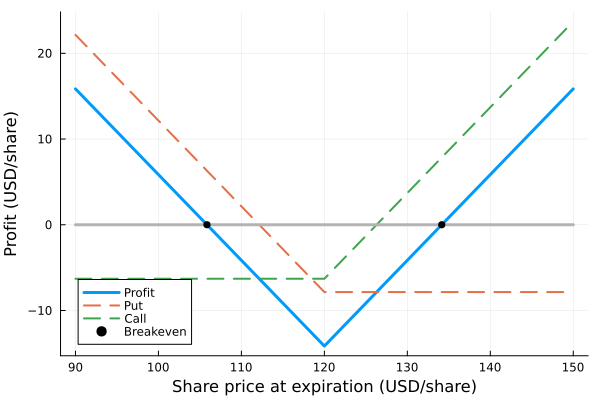

In [4]:
let
    
    K = 120.0
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Midpoint];

    put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium_1, sense = 1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K + (premium_1 + premium_2);
    breakeven_array[2,1] = K - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit")
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash)
    plot!(S,BEL,lw=3, c=:gray70, label="")
    
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="Breakeven")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

### Short straddle
For a short straddle, we sell (are short) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a long straddle with the parameters:

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = 120 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `short call` leg is given by $K_{2}$ = 120 USD/share with `DTE = 31 days`

#### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

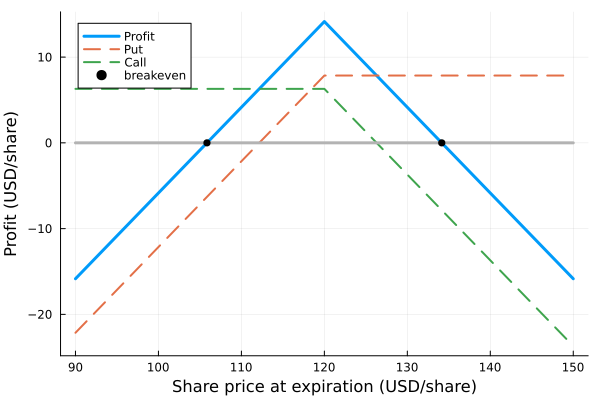

In [5]:
let 
    
    K = 120.0
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Midpoint];


    put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium_1, sense = -1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium_2, sense = -1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K + (premium_1 + premium_2);
    breakeven_array[2,1] = K - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit")
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash)
    
    plot!(S,BEL,lw=3, c=:gray70, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

## Objective 3: Profit and loss diagrams for long and short strangles
A [strangle](https://www.investopedia.com/terms/s/strangle.asp) position is a _neutral strategy_ constructed by simultaneously buying or selling a put and a call option on the same underlying asset `XYZ`, with the _same expiration_ but with _different strike prices_. Depending upon the choice of the strike prices and whether an investor buys or sells both legs, a [strangle](https://www.investopedia.com/terms/s/strangle.asp) can be initiated as a credit or debit and can potentially have undefined profit or loss.

Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the price of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the `put` contract, $j=2$ denote the `call` contract; for a strangle $K_{1}<K_{2}$. 

### Profit and loss for a strangle
The profit for a single strangle contract $\hat{P}$ at expiration is given by:

$$\hat{P} = \theta\cdot\left(P_{1}+P_{2}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a `put` and a `call` contract, the overall profit $\hat{P}$ is given by:

$$\hat{P} = \theta\cdot\Bigl[(K_{1}-S)^{+}+(S-K_{2})^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p} = (K_{1}-S)^{+}=\max(K_{1}-S,0)$ is the `payoff` for the `put` contract, and $V_{c} = (S-K_{2})^{+} = \max(S-K_{2},0)$ is the `payoff` for the `call` contract. The profit (or loss) of a strangle has three regimes given by:

$$
\hat{P} = \begin{cases}
  \theta\cdot\Bigl[(S-K_{2})-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S>K_{2} \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & K_{1}\leq{S}\leq{K_{2}} \\
  \theta\cdot\Bigl[(K_{1}-S)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S<{K_{1}}
\end{cases}
$$

A [strangle](https://www.investopedia.com/terms/s/strangle.asp) has two break-even points $S^{+}$ and $S^{-}$ where $K_{2}<S^{+}$ and $S^{-}<K_{1}$. The low break-even point $S^{-}$ is given by:

$$S^{-} = K_{1} - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$$

while the high break-even point $S^{+}$ is given by:

$$S^{+} = K_{2} + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$$

### Long strangle
For a long strangle, we purchase (are long) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Opening this trade results in a `debit`, where the investor profits when the trade is closed. Let's contruct the profit diagram for a long straddle with the parameters:

* Leg 1: The strike price for the `long put` leg is given by $K_{1}$ = 105 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `long call` leg is given by $K_{2}$ = 135 USD/share with `DTE = 31 days`

#### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

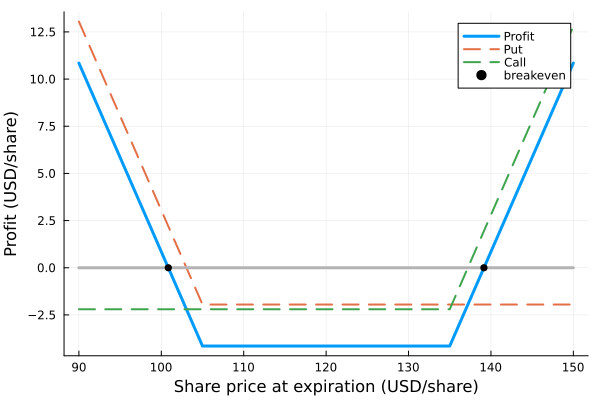

In [6]:
let

    K₁ = 105.0;
    K₂ = 135.0;
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Call"), options_dataset)[1,:Midpoint];
    
    
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = 1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K₂, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit")
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash)
    
    plot!(S,BEL,lw=3, c=:gray70, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

### Short strangle
For a short strangle, we sell (are short) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a long straddle with the parameters:

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = 105 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `short call` leg is given by $K_{2}$ = 135 USD/share with `DTE = 31 days`

#### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

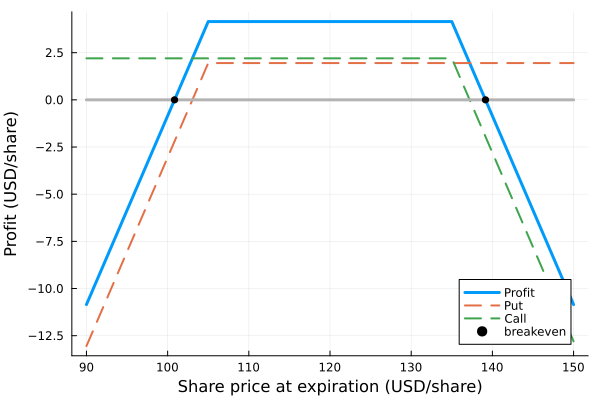

In [7]:
let

    K₁ = 105.0;
    K₂ = 135.0;
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Call"), options_dataset)[1,:Midpoint];
    
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = -1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K₂, premium = premium_2, sense = -1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit")
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash)
    
    plot!(S,BEL,lw=3, c=:gray70, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end